In [182]:
import pandas as pd
import numpy as np
import prophet
from make_series import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


import warnings

warnings.filterwarnings("ignore")

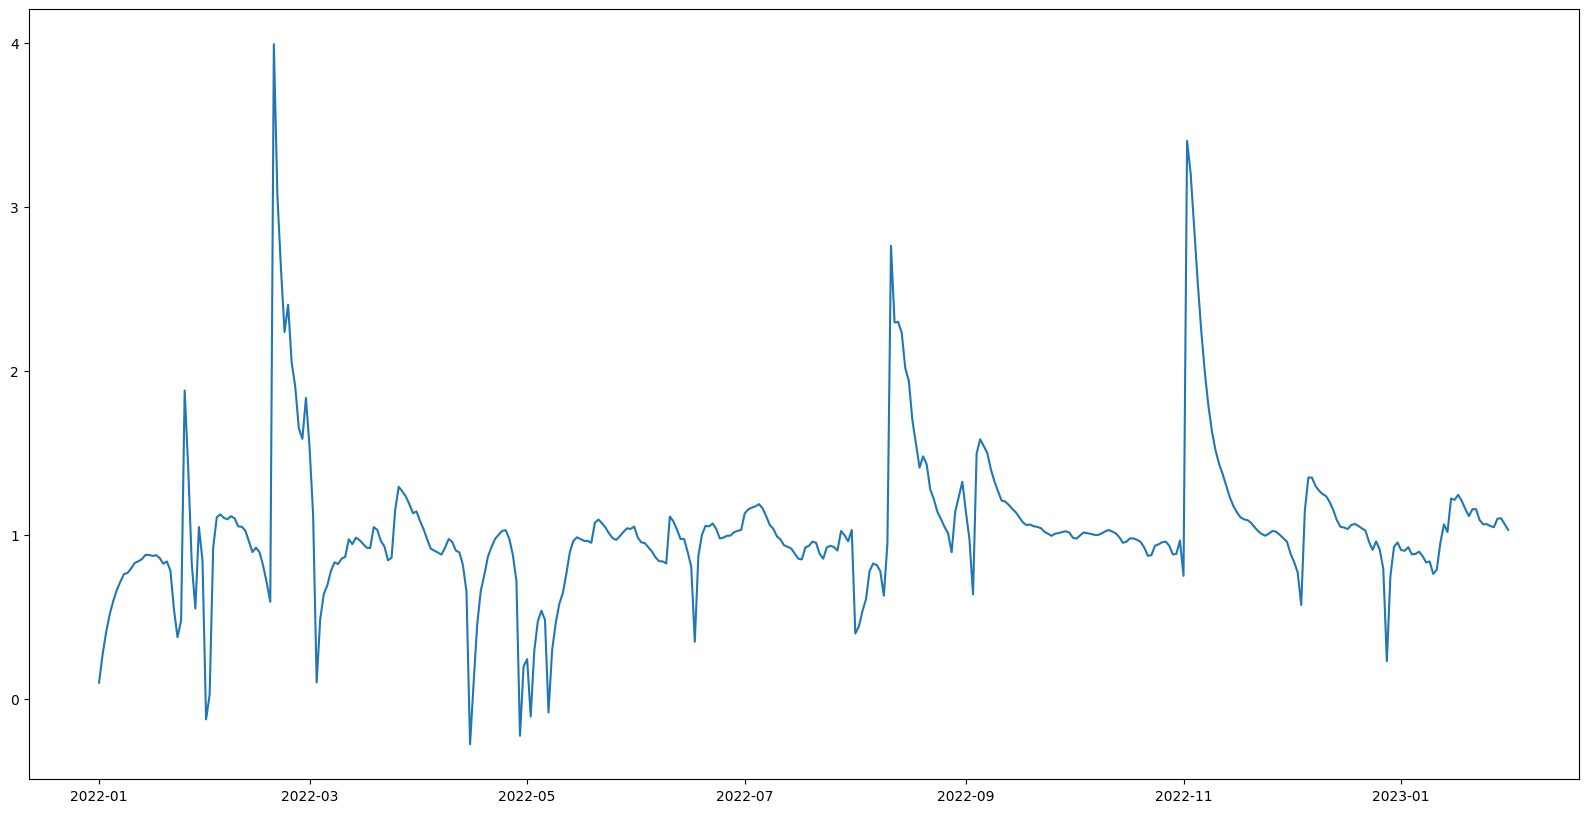

In [183]:
# Соберем нужные данные
df = pd.read_excel('data/normalized_data.xlsx')
series = make_series(df, 'Бакалейные магазины, супермаркеты', is_exponential_smoothing=True)
series_diff = [0.1]
for i in range(1, len(series)):
    if (series[i] / series[i-1] < -5):
        series_diff.append(-4)
    else:
        series_diff.append(series[i] / series[i-1])
    
series_diff = exponential_smoothing(series_diff, 0.2)
dates = get_all_dates()

# Сделаем из 2 столбцов датафрейм
'''
df = pd.DataFrame({'ds': pd.date_range(start='2022-01-01', end='2022-01-30', freq='D'),
                   'y': [2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, ]})
'''

df = pd.DataFrame({'ds': dates, 'y': series_diff})


df['ds'] = pd.to_datetime(df['ds'])

# Сделаем график series
plt.figure(figsize=(20, 10))
plt.plot(df['ds'], df['y'])
plt.show()

# разделим на обучающую и тестовую выборку
predictions = 100
train_df = df[:-predictions]
test_df = df[-predictions:]

In [184]:
# Проверим series_diff на стационарность
test_stationarity(train_df['y'])

Results of Dickey-Fuller Test:
Test Statistic                -6.602825e+00
p-value                        6.669426e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.950000e+02
Critical Value (1%)           -3.452713e+00
Critical Value (5%)           -2.871388e+00
Critical Value (10%)          -2.572017e+00
dtype: float64


In [185]:
# Создадим модель
model = prophet.Prophet()# Включение недельной сезонности
model.add_country_holidays(country_name='RU')
model.fit(train_df)

02:51:58 - cmdstanpy - INFO - Chain [1] start processing
02:51:58 - cmdstanpy - INFO - Chain [1] done processing


In [186]:
# Предскажем значения
future = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future)


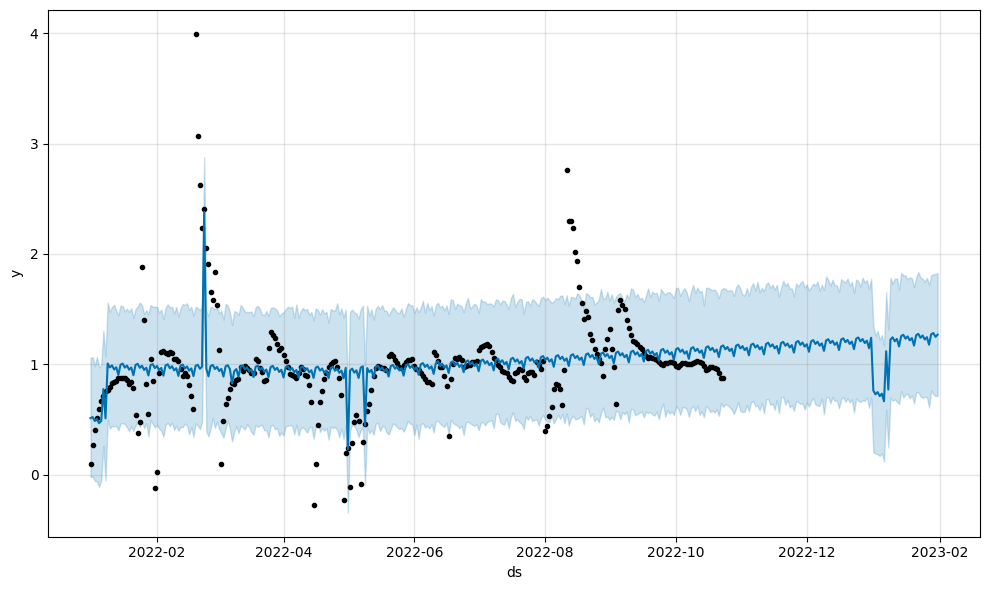

In [187]:
# Посмотрим на графике
fig1 = model.plot(forecast)

In [188]:
# Найдем MAE и MAPE

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
mae = mean_absolute_error(test_df['y'], forecast['yhat'][-predictions:])
mape = mean_absolute_percentage_error(test_df['y'], forecast['yhat'][-predictions:])
mae, mape

(0.28017574226749603, 25.874879163575642)

In [189]:
pd.DataFrame({'y': train_df['y'], 'yhat': forecast['yhat'][:-predictions]})

,y,yhat
0,0.100000,0.513622
1,0.273219,0.523292
2,0.409020,0.486722
3,0.517821,0.505804
4,0.599024,0.468079
...,...,...
291,0.970677,1.113398
292,0.957858,1.134769
293,0.923881,1.066440
294,0.873981,1.161195
